业务简介：物联网卡，可以上网，用于物联网业务。为了鼓励业务，有首6月免费政策。怀疑有公司大量买入，然后当成上网卡转卖以获利。

数据简介：每条记录是一张物联网卡的信息。包括现时状态、每月费用，卡号、开卡的公司、开卡时间等。

数据分析内容：

首先，对原始数据进行Feature engineering. 每条记录，算出费用非0的月份、费用总和，首、末次费用月份，开卡月份。  
其次，进行汇总。按公司、按开卡月份，汇总网卡的状态（共6种）。  
最后，进行简单的可视化，以便观察是否异常。

In [3]:
import pandas as pd
import numpy as np
import os
import shutil
from tabulate import tabulate
pd.options.display.max_columns = 999999
pd.options.display.max_rows = 999999
import numpy
import re
import gc
from collections import defaultdict
from datetime import date
import matplotlib.pyplot as plt

In [4]:
filename = './data/物联网业务客户明细_NEW_201608.csv'
data = pd.read_csv(filename, encoding = 'gbk')
#data是全部数据，900多万条

In [5]:
data.shape

(9120417, 27)

In [6]:
data.head()

,客户名称,客户编号,SIM卡号,手机号,开通时间,状态,结束时间,账单费用201608,账单费用201607,账单费用201606,账单费用201605,账单费用201604,账单费用201603,账单费用201602,账单费用201601,账单费用201512,账单费用201511,账单费用201510,账单费用201509,账单费用201508,账单费用201507,账单费用201506,账单费用201505,账单费用201504,账单费用201503,账单费用201502,账单费用201501
0,北京中易通网络科技有限公司,21100036298818,898602B0011450062205,1064800135079,20150723,开通,NaN,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,于志轩,21100034378108,898602B0011530000029,1064800000161,20150402,停机,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13401009622,21100045072462,NaN,13401009622,20160528,待激活,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,北京神州汽车租赁有限公司,21100035369446,898602B0011450054326,1064800127200,20150707,开通,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,北京神州汽车租赁有限公司,21100035369446,898602B0011450054386,1064800127260,20150707,开通,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data.columns = list(data.columns[:7]) + [str(i) for i in range(19, -1, -1)] + list(data.columns[27:])

In [9]:
month_dict = dict()
for i in range(12):
    month_dict[i] = 201501+i
for i in range(12, 20):
    month_dict[i] = 201601+i-12

#字典方便列数与年月的对应
inverse_dict = dict([[j,i] for (i,j) in month_dict.items()])

In [10]:
inverse_dict

{201501: 0,
 201502: 1,
 201503: 2,
 201504: 3,
 201505: 4,
 201506: 5,
 201507: 6,
 201508: 7,
 201509: 8,
 201510: 9,
 201511: 10,
 201512: 11,
 201601: 12,
 201602: 13,
 201603: 14,
 201604: 15,
 201605: 16,
 201606: 17,
 201607: 18,
 201608: 19}

In [11]:
data['cost_sum'] = data.iloc[:, 7:27].sum(1)
data['start_month'] = (data[u'开通时间']/100).astype(int).apply(lambda x: inverse_dict[x])

下面开始第二步：汇总

In [12]:
status_by_company_and_month = data.groupby([u'客户名称', u'start_month'])[u'状态'].value_counts()

In [13]:
status_by_company_and_month = status_by_company_and_month.unstack(level = 2)

In [14]:
def standarize(df):
    df = df.fillna(0)
    df['sum'] = df.sum(1)
    df = df.astype(int)
    df = df.sort_values(by = 'sum', ascending = False)
    return df

In [15]:
status_by_company_and_month = standarize(status_by_company_and_month)
status_by_company_and_month.head()

状态                             停机      开通    待激活     无主   欠销  申销     sum
客户名称            start_month                                             
深圳市润信凯业通信技术有限公司 9               2  279984      0      0    0   0  279986
深圳市华正信息服务有限公司   14           1751   39637  98294      0  873  13  140568
深圳市润信凯业通信技术有限公司 7               3  140497      0      0    0   0  140500
                17              0  110000      0  30000    0   0  140000
                5               1  130814      0      0    0   0  130815

In [16]:
status_by_company = data.groupby([u'客户名称'])[u'状态'].value_counts()
status_by_company = status_by_company.unstack(level = 1)
status_by_company = standarize(status_by_company)
status_by_company.head()

状态,停机,开通,待激活,无主,欠销,申销,sum
客户名称,,,,,,,
深圳市润信凯业通信技术有限公司,1017,1407199,0,30000,0,0,1438216
深圳市华正信息服务有限公司,106181,581949,99590,0,27779,223,815722
山东金斗云通讯服务有限公司,17211,413794,16048,0,24027,51,471131
上海皇聚投资管理有限公司,33118,182176,0,5,188014,0,403313
北京双得利仪表运营科技有限公司,3,314385,0,0,0,666,315054


In [30]:
big_status_by_company = status_by_company[status_by_company['sum'] >= 10000].sort_values(by = 'sum', ascending = False)

In [44]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(left, height, width=0.8, bottom=None, hold=None, data=None, **kwargs)
    Make a bar plot.
    
    Make a bar plot with rectangles bounded by:
    
      `left`, `left` + `width`, `bottom`, `bottom` + `height`
            (left, right, bottom and top edges)
    
    Parameters
    ----------
    left : sequence of scalars
        the x coordinates of the left sides of the bars
    
    height : sequence of scalars
        the heights of the bars
    
    width : scalar or array-like, optional
        the width(s) of the bars
        default: 0.8
    
    bottom : scalar or array-like, optional
        the y coordinate(s) of the bars
        default: None
    
    color : scalar or array-like, optional
        the colors of the bar faces
    
    edgecolor : scalar or array-like, optional
        the colors of the bar edges
    
    linewidth : scalar or array-like, optional
        width of bar edge(s). If None, use default
      

In [68]:
fees = pd.read_hdf('./data/fees.h5', 'data')

b = fees.groupby(u'客户名称')[['agg_{}'.format(i) for i in range(12)]].sum()
b['sum'] = b.sum(1)
b['count'] = fees.groupby(u'客户名称')['agg_0'].count()
b = b[b['count'] >= 10000]
b = b.astype(int)





In [72]:
a[0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1161fcd50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11730c950>], dtype=object)

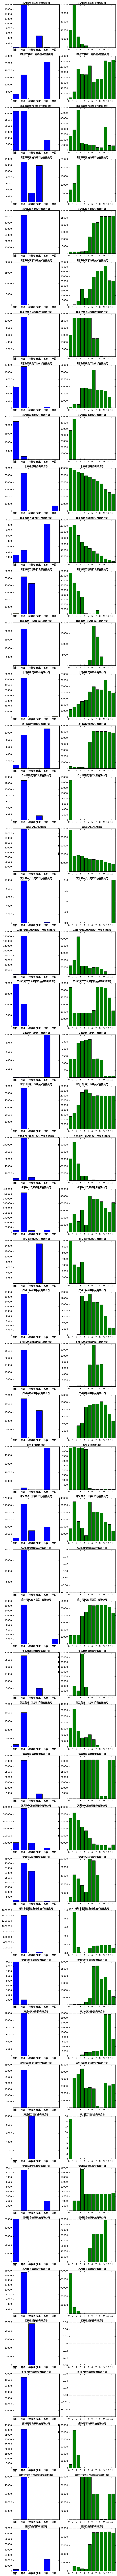

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.font_manager import FontProperties
font_1 = FontProperties(fname = '/Library/Fonts/Yuanti.ttc')
x1 = np.arange(6)
x2 = np.arange(12)

k = 50
start = 50
f, a = plt.subplots(k,2, figsize = (8,4*k))
for i in range(start ,start + k):
    name = b.index[i]
    y1 = big_status_by_company.ix[name].iloc[:6]
    y2 = b.ix[name].iloc[:12]
#z = b.iloc[:,:12].sum(0)set_xticklabels
    a[i-start,0].bar(x1,y1)
#    w = a[i-start].get_width()
    a[i-start,0].set_xticklabels( list(big_status_by_company.columns)[:6], fontproperties = font_1, ha = 'left', va = 'top')
    a[i-start,0].set_title(name, fontproperties = font_1)
    a[i-start,1].bar(x2, y2, tick_label = range(12), color = 'g')
    a[i-start,1].set_title(name, fontproperties = font_1)

In [17]:
status_by_month = data.groupby([u'start_month'])[u'状态'].value_counts()
status_by_month = status_by_month.unstack(level = 1)
status_by_month = standarize(status_by_month)
status_by_month.head()

状态,停机,开通,待激活,无主,欠销,申销,sum
start_month,,,,,,,
17,95690,691805,6758,50691,10,565,845519
14,5068,618767,105916,18455,3607,338,752151
3,72424,404438,0,392,198232,11974,687460
15,7437,598596,12,38820,41783,359,687007
7,40835,506000,482,14994,16733,1570,580614


In [18]:
status_no_fee_by_month = data[data['cost_sum'] == 0].groupby('start_month')['cost_sum'].count()

以下是可视化

In [19]:
status_by_month = status_by_month.sort_index()
status_by_month

状态,停机,开通,待激活,无主,欠销,申销,sum
start_month,,,,,,,
0,11848,308937,1,91,98319,14776,433972
1,6404,109915,0,0,57332,19298,192949
2,9119,169405,0,220,65012,1260,245016
3,72424,404438,0,392,198232,11974,687460
4,24847,327500,0,0,93480,7934,453761
5,99098,258790,0,207,20342,2564,381001
6,12135,220063,0,4634,8582,3284,248698
7,40835,506000,482,14994,16733,1570,580614
8,93460,379510,0,500,19621,5280,498371


In [22]:
help(FontProperties)

Help on class FontProperties in module matplotlib.font_manager:

class FontProperties(__builtin__.object)
 |  A class for storing and manipulating font properties.
 |  
 |  The font properties are those described in the `W3C Cascading
 |  Style Sheet, Level 1
 |  <http://www.w3.org/TR/1998/REC-CSS2-19980512/>`_ font
 |  specification.  The six properties are:
 |  
 |    - family: A list of font names in decreasing order of priority.
 |      The items may include a generic font family name, either
 |      'serif', 'sans-serif', 'cursive', 'fantasy', or 'monospace'.
 |      In that case, the actual font to be used will be looked up
 |      from the associated rcParam in :file:`matplotlibrc`.
 |  
 |    - style: Either 'normal', 'italic' or 'oblique'.
 |  
 |    - variant: Either 'normal' or 'small-caps'.
 |  
 |    - stretch: A numeric value in the range 0-1000 or one of
 |      'ultra-condensed', 'extra-condensed', 'condensed',
 |      'semi-condensed', 'normal', 'semi-expanded', 'expan

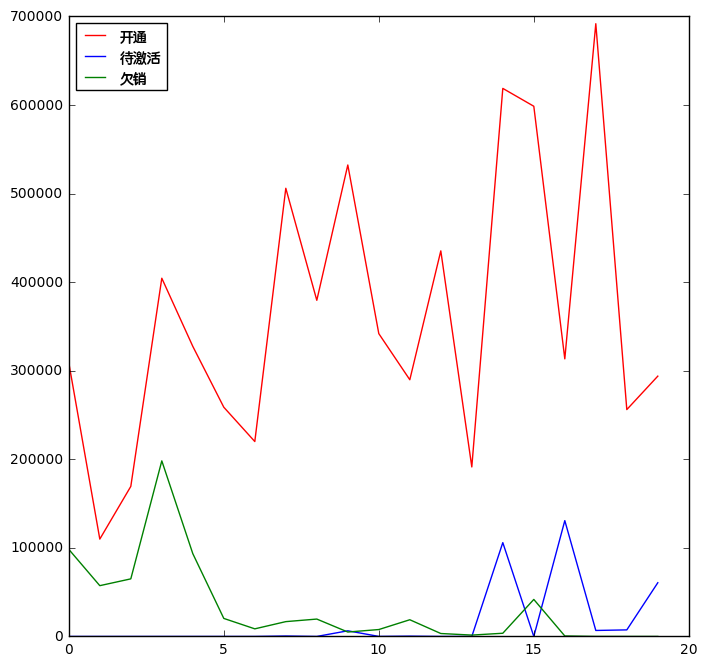

In [93]:
%matplotlib inline
from matplotlib.font_manager import FontProperties
font_1 = FontProperties(fname = '/Library/Fonts/Yuanti.ttc')
all_status = list(status_by_month.columns)[:-1]
f, a = plt.subplots(1,1, figsize = (8,8))
colors = ['black', 'r', 'blue', 'purple','g', 'brown']
for i, item in enumerate(all_status):
    if i in [0,3,5]:
        continue
    a.plot(range(20), status_by_month[item],color = colors[i])
    a.legend(prop = font_1, loc = 0)
    #a[i].set_title(item, fontproperties = font_1)
